<a href="https://colab.research.google.com/github/geee05/Prophet-Library/blob/main/Ethereum_Price_Analysis_and_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Goal__  : Ethereum is the second-largest cryptocurrency by market capitalization, right behind Bitcoin. We wil be performing an exploratory analysis on the data available to us about ethereum prices and attempt to forecast the price for the following day.</br>
Guide notes for the terms that are used throughout this project: </br>
1. __Open__     : The stock’s price at the beginning of trading on a particular day
2. __High__     : The stock’s highest value during a given trading day
3. __Low__      : The lowest price at which a stock trades on a given day
4. __Close__    : This is the last price at which a stock traded during a given trading day
5. __Adj Close__: Including any corporate actions, this is the stock’s closing price.
6. __Volume__   : During a particular period, the number of shares traded in a stock

## IMPORTING THE NECESSARY DEPENENCIES

In [ ]:
#!pip install prophet
from prophet import Prophet 

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '${:,.2f}'.format

In [ ]:
#let's get the info for all the dates from 2016 to today's date
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2016-01-01'

eth_df = yf.download('ETH-USD',start_date, today)

eth_df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,"$1,870.69","$1,915.50","$1,845.87","$1,904.65","$1,904.65",8306390869
2023-05-04,"$1,905.17","$1,915.87","$1,868.63","$1,877.70","$1,877.70",6578438233
2023-05-05,"$1,877.83","$1,998.41","$1,876.95","$1,995.06","$1,995.06",9498261360
2023-05-06,"$1,995.48","$2,017.56","$1,870.61","$1,900.22","$1,900.22",9623243037
2023-05-07,"$1,899.92","$1,934.00","$1,873.08","$1,873.08","$1,873.08",6883942236


In [ ]:
eth_df.to_csv('ETH-USD.csv',index=False)

## PRE-PROCESSING OF DATA

In [ ]:
#understanding the data
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2006 entries, 2017-11-09 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2006 non-null   float64
 1   High       2006 non-null   float64
 2   Low        2006 non-null   float64
 3   Close      2006 non-null   float64
 4   Adj Close  2006 non-null   float64
 5   Volume     2006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 109.7 KB


note: date is not mentioned as one of the columns; it is appearing as the index.

In [ ]:
eth_df.reset_index(inplace=True)
eth_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
#index has been reset and now we have date column
eth_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2001,2023-05-03,"$1,870.69","$1,915.50","$1,845.87","$1,904.65","$1,904.65",8306390869
2002,2023-05-04,"$1,905.17","$1,915.87","$1,868.63","$1,877.70","$1,877.70",6578438233
2003,2023-05-05,"$1,877.83","$1,998.41","$1,876.95","$1,995.06","$1,995.06",9498261360
2004,2023-05-06,"$1,995.48","$2,017.56","$1,870.61","$1,900.22","$1,900.22",9623243037
2005,2023-05-07,"$1,899.92","$1,934.00","$1,873.08","$1,873.08","$1,873.08",6883942236


In [ ]:
eth_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## EXPLORATORY DATA ANALYSIS 

In [ ]:
import statsmodels.api as sm

#### OBSERVING WHAT THE TREND LINE FOR ETHEREUM PRICES LOOKS LIKE :

In [ ]:
#getting the index as a numerical array
eth_df['Index']=range(len(eth_df))
X=sm.add_constant(eth_df['Index'])
Y=eth_df['Open'].values

#fitting linear regression to opening price
trend_model = sm.OLS(Y,X).fit()

#obtaining slope and intercept
slope=trend_model.params[1]
intercept=trend_model.params[0]

Text(0, 0.5, 'Opening Price')

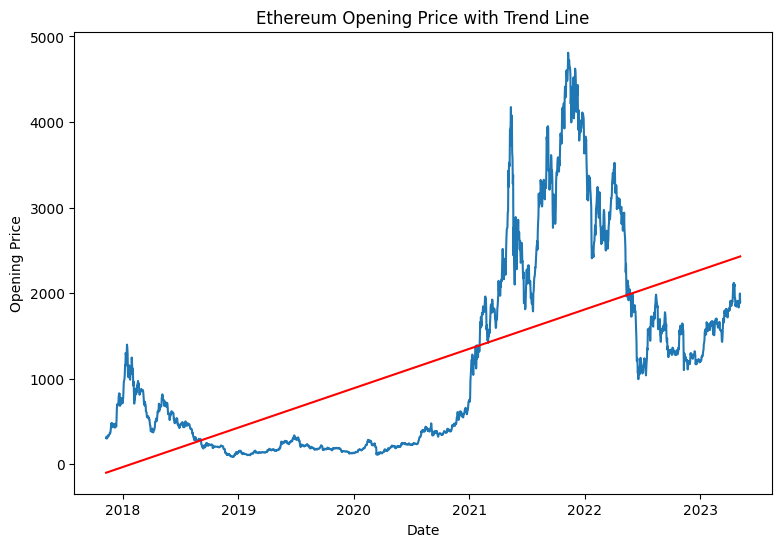

In [ ]:
#plotting the trend axix for the opening prices of Ethereum
plt.figure(figsize=(9,6))
plt.plot(eth_df['Date'],eth_df['Open'])
plt.plot(eth_df['Date'], slope*eth_df['Index']+intercept,color='red')
plt.title('Ethereum Opening Price with Trend Line')
plt.xlabel('Date')
plt.ylabel('Opening Price')

#### OBSERVING THE SEASONALITY OF DATA:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'April'),
  Text(1, 0, 'May'),
  Text(2, 0, 'February'),
  Text(3, 0, 'March'),
  Text(4, 0, 'November'),
  Text(5, 0, 'January'),
  Text(6, 0, 'October'),
  Text(7, 0, 'August'),
  Text(8, 0, 'December'),
  Text(9, 0, 'September'),
  Text(10, 0, 'June'),
  Text(11, 0, 'July')])

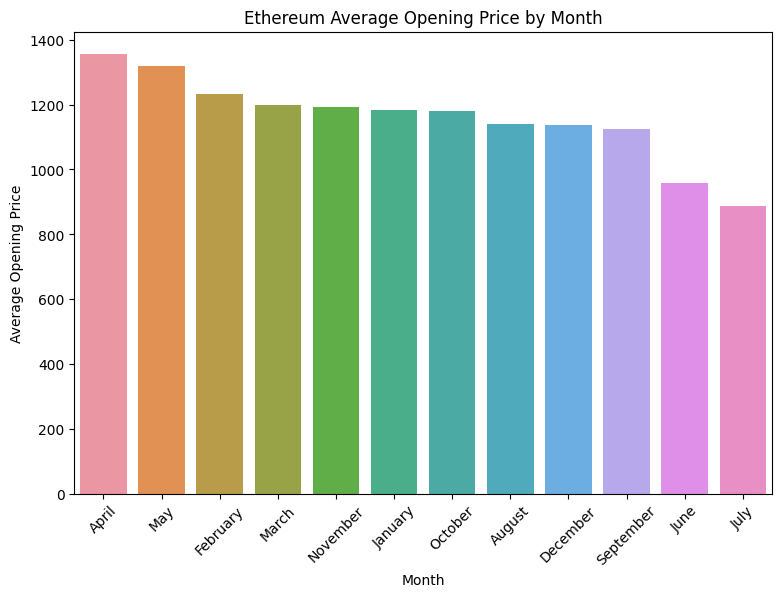

In [ ]:
eth_df['Month']=eth_df['Date'].dt.month_name()
monthly_mean=eth_df.groupby('Month')['Open'].mean().sort_values(ascending=False)

plt.figure(figsize=(9,6))
sns.barplot(x=monthly_mean.index, y=monthly_mean.values)
plt.title('Ethereum Average Opening Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Opening Price')
plt.xticks(rotation=45)

## BUILDING A MODEL FOR FORECASTING THE PRICES 

#### Fbprophet Model:

In [ ]:
#prophet takes only ds and y as input columns
df = eth_df[["Date", "Open"]]

df.columns=['ds','y']

In [ ]:
# plot the open price

#assign x,y values
x = df["ds"]
y = df["y"]

#create a figure
fig = go.Figure()

#a different trace will be created for each unique value
fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(
    title_text="Time series plot for Ethereum Open Price",
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)

* 5 spikes observed : two major spikes in may,nov 2021 </br>
* We can also tell that the fluctuation in our price exaggerates as year increases. This could signify the type of time series data this is.

In [ ]:
#building the prophet model
model = Prophet(
    seasonality_mode="multiplicative" 
)

model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9ylo_yyg/7e63qoxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9ylo_yyg/mib9s7n0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22474', 'data', 'file=/tmp/tmp9ylo_yyg/7e63qoxr.json', 'init=/tmp/tmp9ylo_yyg/mib9s7n0.json', 'output', 'file=/tmp/tmp9ylo_yyg/prophet_modeld5qy95bb/prophet_model-20230508125754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:57:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#making dataframe containing future dates for forecast
future = model.make_future_dataframe(periods = 30)
future.tail()

,ds
2031,2023-06-02
2032,2023-06-03
2033,2023-06-04
2034,2023-06-05
2035,2023-06-06


In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat','yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2031,2023-06-02,"$1,113.34",$853.21,"$1,359.95"
2032,2023-06-03,"$1,088.24",$849.37,"$1,349.35"
2033,2023-06-04,"$1,075.74",$803.17,"$1,338.40"
2034,2023-06-05,"$1,062.21",$808.17,"$1,331.79"
2035,2023-06-06,"$1,045.82",$774.87,"$1,306.59"


In [ ]:
#getting the forecast for the following day
next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

prediction=forecast[forecast['ds'] == next_day]['yhat'].item()

In [ ]:
prediction

1689.2269183513417

In [ ]:
plot_plotly(model, forecast)

In [ ]:
#growth curve trend, weekly seasonal, and yearly seasonal components
plot_components_plotly(model, forecast)

## SAVING THE MODEL FOR FUTURE USE

In [ ]:
import pickle

In [ ]:
with open('fbProphet.pkl', "wb") as f:
    pickle.dump(model, f)